In [9]:
!pip install "numpy<2" "shap<0.45" "scikit-learn>=1.3" "imbalanced-learn>=0.12" "streamlit>=1.30" --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 39.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 38.1 MB/s eta 0:00:0000:010:01
  Attempting uninstall: cachetools
    Found existing installation: cachetools 5.3.3
    Uninstalling cachetools-5.3.3:
      Successfully uninstalled cachetools-5.3.3
  Attempting uninstall: pandas
    Found existing installation: pandas 3.0.0
    Uninstalling pandas-3.0.0:
      Successfully uninstalled pandas-3.0.0
  Attempting uninstall: streamlit
    Found existing installation: streamlit 1.32.0
    Uninstalling streamlit-1.32.0:
      Successfully uninstalled streamlit-1.32.0


In [5]:
import numpy as np
print(f"NumPy version: {np.__version__}")

NumPy version: 1.26.4


In [3]:
# Pregnancy Risk Calculator Model Training Notebook
# Import libraries
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import matplotlib.pyplot as plt
# !pip install seaborn  # Comment this out too!
import seaborn as sns
from sklearn.utils import resample

In [7]:
# Updated: Calculator 1:
# Predictors: Maternal Age, NtMoM (Change to CRL and Nt, so users don't need an outside source for the NTMoM calculation), NIPT results
# Outcomes: Composite, Structural, ChromProbs, Livebirth, SAB, (+ "T21", "T18", "T13", "Turners", "OtherChroms") --> The additional part
# Load dataset
data = pd.read_csv("CH_Dataset_0623.csv")

# Drop irrelevant columns
drop_cols = ['Record ID', "Ethnicity", "NonAsian", "AnomalyType", "AnomalyDescribe", "AnomalyDescribe2",
             "ChromsProb_Other", "SABGA_w", "SABGA_d", "IAB", "IABGA_w", "IABGA_D",
             "Dmode", "GeneticAndAnomaly", 'PosNIPTtype',
             'UnreportableNIPT', 'VISTARA_posneg', 'VISTARA_type', 'DxtestingGA-w', 'DxtestingGA-d', 'FFSGA_w',
             'FFSGA_d', 'FFS_Nfsize', 'NTGA-w', 'NTGA-d','NTExpect', 'CRLrounded',
             'FFS_Chchange (0=No comment, 1= CH smaller, 2=CH resolved, 3=CH bigger, 4=CH same)',
             'OtherUS_Chchange (0=No comment, 1= CH smaller, 2=CH resolved, 3=CH bigger, 4=CH same)', 'Gcvisit_YN', 
            'AvailGenInfo','Gctests', 'Dxtesting', 'FFS_YN','AneuploidyType','White','Black', 'Asian', 'MiddleEastern', 'Latin', 'Native', 'Other']
data.drop(columns=drop_cols, errors='ignore', inplace=True)

data.rename(columns={'NIPT results (Neg = 0, Pos=1, Not report=2)': 'NIPT_results'}, inplace=True)

# Convert NT and CRL to numeric (force errors to NaN)
data['NT'] = pd.to_numeric(data['NT'], errors='coerce')
data['CRL'] = pd.to_numeric(data['CRL'], errors='coerce')
# Calculate NTMoM_cal
data['NTMoM_cal'] = data['NT'] / (0.437 + 0.01969 * data['CRL'])
# Drop original NtMoM (Wrong Calculation)
data.drop(columns=['NtMoM'], inplace=True, errors='ignore')

# Define continuous and categorical variables
continuous_vars = ['Age', 'NTMoM_cal']
categorical_vars = ['NIPT_results']

# Removed so no longer relevant
# Handle ResolvedCH missing as 'Not Reported' (set as 2 for modeling)
#data['ResolvedCH'] = data['ResolvedCH'].replace({np.nan: 2})

# View missing summary
missing_summary = (
    data.isnull()
    .mean()
    .reset_index()
    .rename(columns={'index': 'Variable', 0: 'MissingProportion'})
    .sort_values(by='MissingProportion', ascending=False)
)
print(missing_summary)


        Variable  MissingProportion
15     NTMoM_cal           0.058824
2            CRL           0.055556
1             NT           0.042484
0            Age           0.039216
3   NIPT_results           0.039216
4     ResolvedCH           0.039216
5        Anomaly           0.039216
6     ChromsProb           0.039216
7            SAB           0.039216
8      Livebirth           0.039216
9      Composite           0.039216
10           T21           0.039216
11           T18           0.039216
12           T13           0.039216
13       Turners           0.039216
14   OtherChroms           0.039216


In [9]:
# Define continuous and categorical variables
continuous_vars = ['Age', 'NTMoM_cal']
categorical_vars = ['NIPT_results']
target_vars = ['Composite', 'Anomaly', 'ChromsProb', 'SAB', 'Livebirth', "T21", "T18", "T13", "Turners", "OtherChroms"]

# Drop rows with missing or '.' in target variables
initial_rows = data.shape[0]
data = data[~data[target_vars].isnull().any(axis=1)]
data = data[~(data[target_vars] == ".").any(axis=1)]
data = data[~(data[target_vars] == "nan").any(axis=1)]
print(f"\nDropped rows with missing or '.' in targets: {initial_rows - data.shape[0]}")

# Convert 'NIPT_results' to numeric and fill problematic values with 2
data['NIPT_results'] = pd.to_numeric(data['NIPT_results'], errors='coerce').fillna(2).astype(int)

# Convert all continuous vars to numeric, coerce bad entries (like '.')
for col in continuous_vars:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Print value counts of targets
print("\nTarget variable value counts after cleaning:")
for target in target_vars:
    if target in data.columns:
        print(f"{target}:\n{data[target].value_counts(dropna=False)}")

# Print predictor row counts before/after drop for each target
for target in target_vars:
    if target not in data.columns:
        continue

    df_target = data[pd.to_numeric(data[target], errors='coerce').notna()].copy()
    df_target[target] = pd.to_numeric(df_target[target], errors='coerce').astype(int)

    before_drop = df_target.shape[0]
    df_target = df_target.dropna(subset=continuous_vars + categorical_vars)
    after_drop = df_target.shape[0]

    print(f"\nTarget: {target}")
    print(f"Rows before dropping invalid predictors: {before_drop}")
    print(f"Rows after dropping invalid predictors:  {after_drop}")
 


Dropped rows with missing or '.' in targets: 42

Target variable value counts after cleaning:
Composite:
Composite
1.0    213
0.0     51
Name: count, dtype: int64
Anomaly:
Anomaly
0    203
1     61
Name: count, dtype: int64
ChromsProb:
ChromsProb
1    177
0     87
Name: count, dtype: int64
SAB:
SAB
0    220
1     44
Name: count, dtype: int64
Livebirth:
Livebirth
0    196
1     68
Name: count, dtype: int64
T21:
T21
0.0    191
1.0     73
Name: count, dtype: int64
T18:
T18
0.0    225
1.0     39
Name: count, dtype: int64
T13:
T13
0.0    250
1.0     14
Name: count, dtype: int64
Turners:
Turners
0.0    241
1.0     23
Name: count, dtype: int64
OtherChroms:
OtherChroms
0.0    236
1.0     28
Name: count, dtype: int64

Target: Composite
Rows before dropping invalid predictors: 264
Rows after dropping invalid predictors:  259

Target: Anomaly
Rows before dropping invalid predictors: 264
Rows after dropping invalid predictors:  259

Target: ChromsProb
Rows before dropping invalid predictors: 264


In [11]:
for col in continuous_vars:
    bad_vals = data[col][~data[col].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()]
    if not bad_vals.empty:
        print(f"Bad values in {col}: {bad_vals.unique()}")

Bad values in NTMoM_cal: [nan]


In [13]:
import sklearn
print(sklearn.__version__)

1.8.0


In [15]:


print("\nUnique values in 'Composite':")
print(df_target['Composite'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'Anomaly':")
print(df_target['Anomaly'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'ChromsProb':")
print(df_target['ChromsProb'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'T21':")
print(df_target['T21'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'T18':")
print(df_target['T18'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'T13':")
print(df_target['T13'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'Turners':")
print(df_target['Turners'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'OtherChroms':")
print(df_target['OtherChroms'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'SAB':")
print(df_target['SAB'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'Livebirth':")
print(df_target['Livebirth'].value_counts(dropna=False).sort_index())


print("\nUnique values in 'NIPT_results':")
print(df_target['NIPT_results'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'ResolvedCH':")
print(df_target['ResolvedCH'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'NTMoM_cal':")
print(df_target['NTMoM_cal'].value_counts(dropna=False).sort_index())

str_nan_count = (df_target['NTMoM_cal'] == "nan").sum()
print(f"String 'nan': {str_nan_count}")
dot_count = (df_target['NTMoM_cal'] == ".").sum()
print(f"Dot ('.'): {dot_count}")
nan_count = df_target['NTMoM_cal'].isna().sum()
print(f"NaN (np.nan): {nan_count}")


Unique values in 'Composite':
Composite
0.0     49
1.0    210
Name: count, dtype: int64

Unique values in 'Anomaly':
Anomaly
0    201
1     58
Name: count, dtype: int64

Unique values in 'ChromsProb':
ChromsProb
0     83
1    176
Name: count, dtype: int64

Unique values in 'T21':
T21
0.0    187
1.0     72
Name: count, dtype: int64

Unique values in 'T18':
T18
0.0    220
1.0     39
Name: count, dtype: int64

Unique values in 'T13':
T13
0.0    245
1.0     14
Name: count, dtype: int64

Unique values in 'Turners':
Turners
0.0    236
1.0     23
Name: count, dtype: int64

Unique values in 'OtherChroms':
OtherChroms
0    231
1     28
Name: count, dtype: int64

Unique values in 'SAB':
SAB
0    215
1     44
Name: count, dtype: int64

Unique values in 'Livebirth':
Livebirth
0    194
1     65
Name: count, dtype: int64

Unique values in 'NIPT_results':
NIPT_results
0     56
1     84
2    119
Name: count, dtype: int64

Unique values in 'ResolvedCH':
ResolvedCH
.    176
0     57
1     26
Name: coun

In [17]:
# Renaming the data variables
data = data.rename(columns={
    "T21": "Trisomy 21 (Down syndrome)",
    "T18": "Trisomy 18",
    "T13": "Trisomy 13",
    "Turners": "Monosomy X (Turner syndrome)",
    "ChromsProb": "Common aneuploidy (T21, T13, T18, Monosomy X)",
    "OtherChroms": "Other genetic diagnoses"
})

In [29]:
# Evaluates all models across all targets
# Define models
models = {
    'Lasso_Logistic_Regression': LogisticRegression(solver='saga', max_iter=1000, C=1.0, l1_ratio=1.0, random_state=42),
    'Ridge_Logistic_Regression': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, C=1.0, random_state=42),
    'Random_Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM_RBF': SVC(kernel='rbf', probability=True, random_state=42),
    'SVM_Linear': SVC(kernel='linear', probability=True, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'Naive_Bayes': BernoulliNB(),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=1000, random_state=42)  # Increase from 300 to 1000
}

# Define metrics
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef),
    'roc_auc': 'roc_auc'
}

target_vars = [
    'Composite', 'Anomaly', 'Common aneuploidy (T21, T13, T18, Monosomy X)',
    'SAB', 'Livebirth', 
    "Trisomy 21 (Down syndrome)", "Trisomy 18", "Trisomy 13",
    "Monosomy X (Turner syndrome)", "Other genetic diagnoses"
]
all_results = {}

for target in target_vars:
    if target not in data.columns:
        print(f"{target} not found in data, skipping.")
        continue

    print(f"\n==== Evaluating for target: {target} ====")
    
    data_target = data[pd.to_numeric(data[target], errors='coerce').notna()].copy()
    data_target[target] = pd.to_numeric(data_target[target], errors='coerce').astype(int)

    X = data_target[continuous_vars + categorical_vars].copy()
    y = data_target[target]

    # Impute only for continuous (NtMoM)
    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', IterativeImputer(random_state=42)),
            ('scaler', StandardScaler())
        ]), continuous_vars),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_vars)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {}

    for name, model in models.items():
        print(f"Evaluating {name} for {target}...")
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', model)
        ])
        try:
            scores = cross_validate(pipeline, X, y, cv=cv, scoring=scorers, n_jobs=-1)
            results[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scorers}
        except Exception as e:
            print(f"Error wit sh {name} on {target}: {e}")

    metrics_df = pd.DataFrame(results).T
    all_results[target] = metrics_df
    metrics_df.to_csv(f"{target}_model_evaluation_results.csv")
    print(f"\nResults for {target}:\n{metrics_df}")




==== Evaluating for target: Composite ====
Evaluating Lasso_Logistic_Regression for Composite...
Evaluating Ridge_Logistic_Regression for Composite...
Evaluating Random_Forest for Composite...
Evaluating SVM_RBF for Composite...
Evaluating SVM_Linear for Composite...
Evaluating XGBoost for Composite...
Evaluating Naive_Bayes for Composite...
Evaluating KNN for Composite...
Evaluating MLP for Composite...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Results for Composite:
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.723730   0.941128  0.704651  0.804051  0.414094   
Ridge_Logistic_Regression  0.723730   0.941128  0.704651  0.804051  0.414094   
Random_Forest              0.742453   0.874758  0.798007  0.833252  0.275543   
SVM_RBF                    0.681785   0.919109  0.666999  0.770348  0.335421   
SVM_Linear                 0.700943   0.940264  0.681395  0.784427  0.380978   
XGBoost                    0.730987   0.859797  0.798117  0.826884  0.228233   
Naive_Bayes                0.723440   0.941847  0.704319  0.803048  0.415107   
KNN                        0.742308   0.918005  0.751052  0.824011  0.385239   
MLP                        0.719666   0.923865  0.713843  0.803315  0.379198   

                            roc_auc  
Lasso_Logistic_Regression  0.801532  
Ridge_Logistic_Regression  0.800515  
Random_Forest              0.757062  
SVM_RBF                

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Results for Anomaly:
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.553338   0.256672  0.493590  0.334803  0.056269   
Ridge_Logistic_Regression  0.557112   0.258788  0.493590  0.336854  0.060310   
Random_Forest              0.659289   0.285703  0.294872  0.286406  0.066513   
SVM_RBF                    0.549419   0.189436  0.296154  0.227659 -0.070259   
SVM_Linear                 0.507692   0.254548  0.574359  0.344721  0.055793   
XGBoost                    0.629100   0.271747  0.342308  0.300679  0.055947   
Naive_Bayes                0.538099   0.254297  0.494872  0.327493  0.043468   
KNN                        0.575980   0.232335  0.360256  0.280644  0.000935   
MLP                        0.594848   0.243990  0.361538  0.289683  0.022979   

                            roc_auc  
Lasso_Logistic_Regression  0.530915  
Ridge_Logistic_Regression  0.529321  
Random_Forest              0.550582  
SVM_RBF                  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_netwo


Results for SAB:
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.579173   0.224033  0.613889  0.326984  0.140578   
Ridge_Logistic_Regression  0.579173   0.224033  0.613889  0.326984  0.140578   
Random_Forest              0.719666   0.208506  0.250000  0.221740  0.057894   
SVM_RBF                    0.568287   0.160606  0.388889  0.226488 -0.006958   
SVM_Linear                 0.462337   0.188223  0.658333  0.288978  0.064587   
XGBoost                    0.746226   0.215873  0.250000  0.228133  0.080828   
Naive_Bayes                0.598331   0.229925  0.566667  0.322270  0.133842   
KNN                        0.643904   0.210733  0.411111  0.276862  0.081318   
MLP                        0.659216   0.197203  0.366667  0.253365  0.064473   

                            roc_auc  
Lasso_Logistic_Regression  0.624495  
Ridge_Logistic_Regression  0.625758  
Random_Forest              0.588384  
SVM_RBF                    0.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_netwo


Results for Livebirth:
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.742308   0.520833  0.587912  0.529952  0.376311   
Ridge_Logistic_Regression  0.734761   0.499405  0.587912  0.521644  0.360740   
Random_Forest              0.776343   0.565837  0.632967  0.588279  0.445401   
SVM_RBF                    0.742308   0.527314  0.604396  0.538979  0.385826   
SVM_Linear                 0.802903   0.630549  0.542857  0.573109  0.456527   
XGBoost                    0.742308   0.510833  0.573626  0.528859  0.364692   
Naive_Bayes                0.787808   0.599672  0.542857  0.554718  0.429556   
KNN                        0.704427   0.470158  0.663736  0.539615  0.355431   
MLP                        0.742453   0.513167  0.604396  0.541641  0.379860   

                            roc_auc  
Lasso_Logistic_Regression  0.806116  
Ridge_Logistic_Regression  0.806491  
Random_Forest              0.759706  
SVM_RBF                

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Results for Trisomy 21 (Down syndrome):
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.659434   0.440073  0.669524  0.521442  0.301893   
Ridge_Logistic_Regression  0.651814   0.430230  0.669524  0.515718  0.290585   
Random_Forest              0.625181   0.355927  0.451429  0.395088  0.133366   
SVM_RBF                    0.670682   0.437090  0.586667  0.496205  0.270609   
SVM_Linear                 0.701016   0.485171  0.573333  0.515510  0.313698   
XGBoost                    0.647968   0.397132  0.505714  0.437135  0.197070   
Naive_Bayes                0.712337   0.498504  0.559048  0.517944  0.323441   
KNN                        0.624964   0.382148  0.573333  0.456737  0.198515   
MLP                        0.628955   0.370274  0.505714  0.423180  0.168008   

                            roc_auc  
Lasso_Logistic_Regression  0.727881  
Ridge_Logistic_Regression  0.728571  
Random_Forest              0.649143  
SVM_RB

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Results for Trisomy 18:
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.697388   0.283415  0.646429  0.388606  0.267992   
Ridge_Logistic_Regression  0.697388   0.283415  0.646429  0.388606  0.267992   
Random_Forest              0.735051   0.243333  0.360714  0.289429  0.139356   
SVM_RBF                    0.662990   0.241903  0.564286  0.333020  0.186611   
SVM_Linear                 0.720029   0.300461  0.646429  0.405273  0.291421   
XGBoost                    0.753991   0.235245  0.303571  0.261236  0.120775   
Naive_Bayes                0.720029   0.300461  0.646429  0.405273  0.291421   
KNN                        0.632729   0.188994  0.467857  0.267289  0.093257   
MLP                        0.662845   0.208627  0.460714  0.283328  0.120894   

                            roc_auc  
Lasso_Logistic_Regression  0.692698  
Ridge_Logistic_Regression  0.694206  
Random_Forest              0.602024  
SVM_RBF               

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_netwo


Results for Trisomy 13:
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.628810   0.060343  0.400000  0.104101  0.023923   
Ridge_Logistic_Regression  0.636357   0.070432  0.466667  0.121687  0.057609   
Random_Forest              0.852322   0.086667  0.200000  0.119658  0.059139   
SVM_RBF                    0.742671   0.078242  0.400000  0.129299  0.079244   
SVM_Linear                 0.598549   0.062367  0.466667  0.109046  0.038124   
XGBoost                    0.863716   0.106667  0.133333  0.116667  0.049553   
Naive_Bayes                0.671190   0.066813  0.466667  0.116002  0.065768   
KNN                        0.742743   0.058333  0.266667  0.093368  0.017391   
MLP                        0.818360   0.100769  0.266667  0.137912  0.077244   

                            roc_auc  
Lasso_Logistic_Regression  0.644000  
Ridge_Logistic_Regression  0.648000  
Random_Forest              0.511333  
SVM_RBF               

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_netwo


Results for Monosomy X (Turner syndrome):
                           accuracy  precision  recall        f1       mcc  \
Lasso_Logistic_Regression  0.837083   0.321409    0.78  0.451662  0.429325   
Ridge_Logistic_Regression  0.833309   0.315804    0.78  0.446816  0.423846   
Random_Forest              0.859869   0.297143    0.47  0.349702  0.295389   
SVM_RBF                    0.841074   0.307967    0.65  0.412493  0.370250   
SVM_Linear                 0.829536   0.301282    0.74  0.424276  0.396118   
XGBoost                    0.878810   0.280556    0.38  0.313736  0.258822   
Naive_Bayes                0.738462   0.225844    0.83  0.353316  0.338108   
KNN                        0.833309   0.238730    0.52  0.318848  0.270293   
MLP                        0.856241   0.340000    0.61  0.426029  0.380007   

                            roc_auc  
Lasso_Logistic_Regression  0.890446  
Ridge_Logistic_Regression  0.888780  
Random_Forest              0.844054  
SVM_RBF                 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


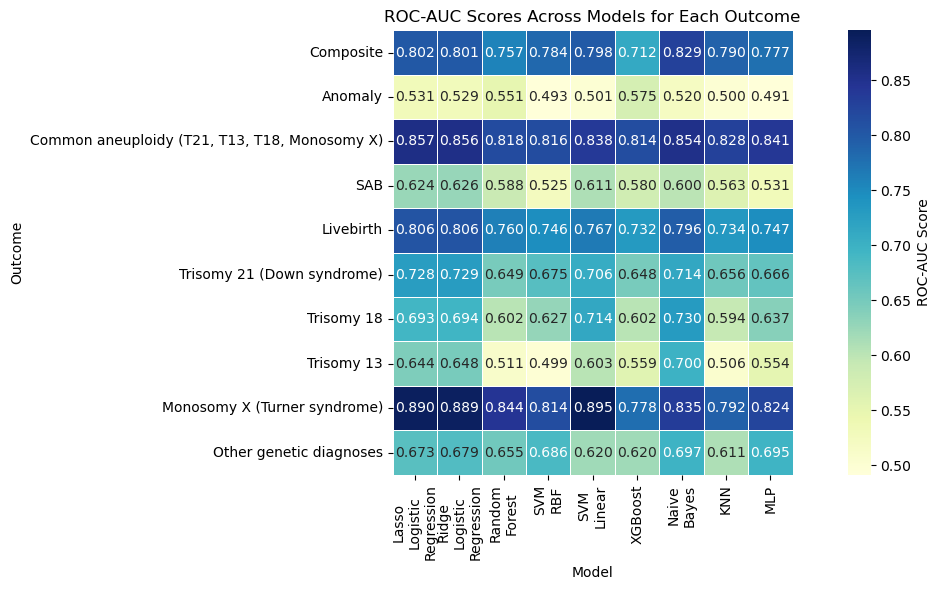

Heatmap saved as roc_auc_heatmap.png


In [31]:
# Collect ROC-AUC scores into a DataFrame - SKIP EMPTY RESULTS
roc_auc_df = pd.DataFrame({
    target: all_results[target]['roc_auc']
    for target in all_results.keys()
    if not all_results[target].empty  # Skip empty DataFrames
}).T  # Transpose to have outcomes as rows

# Clean model names for plot readability
roc_auc_df.columns = [col.replace('_', '\n') for col in roc_auc_df.columns]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    roc_auc_df,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    cbar_kws={'label': 'ROC-AUC Score'},
    linewidths=0.5,
    square=True
)
plt.title("ROC-AUC Scores Across Models for Each Outcome")
plt.ylabel("Outcome")
plt.xlabel("Model")
plt.tight_layout()
plt.savefig("roc_auc_heatmap.png", dpi=300)
plt.show()
print("Heatmap saved as roc_auc_heatmap.png")


==== Coefficient and SHAP Analysis (LASSO) for Composite ====


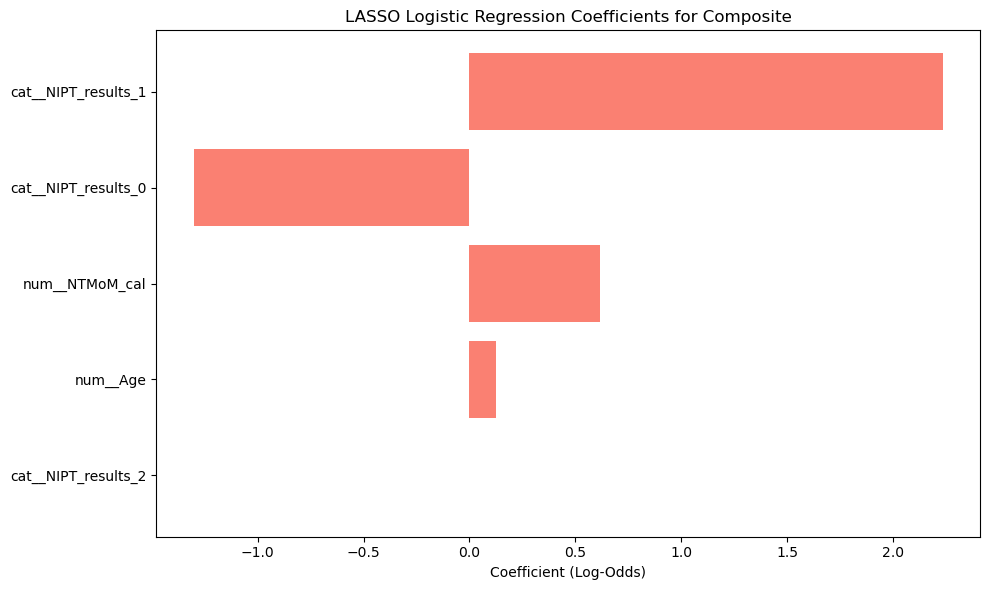

               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.125887
1       num__NTMoM_cal     0.617502
2  cat__NIPT_results_0    -1.301769
3  cat__NIPT_results_1     2.233384


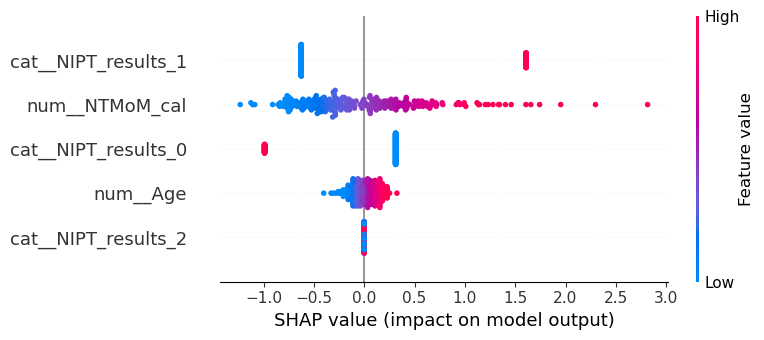


==== Coefficient and SHAP Analysis (LASSO) for Anomaly ====


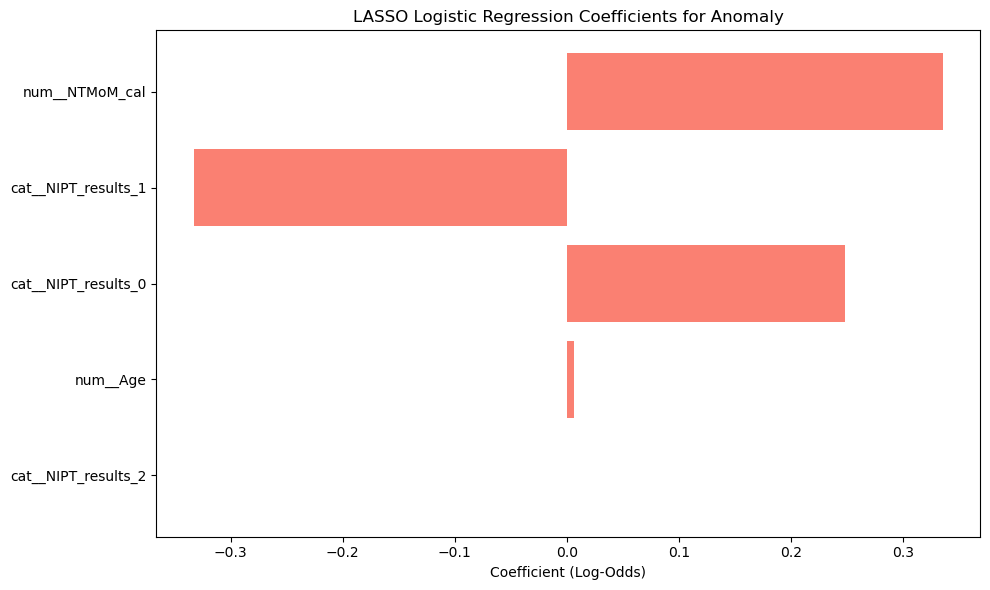

               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.006262
2  cat__NIPT_results_0     0.248252
3  cat__NIPT_results_1    -0.333085
1       num__NTMoM_cal     0.335589


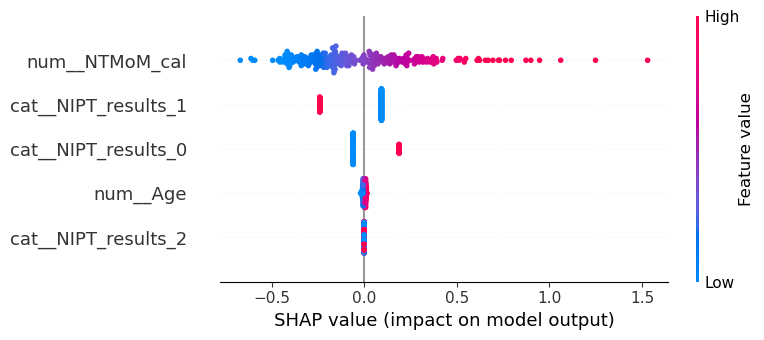


==== Coefficient and SHAP Analysis (LASSO) for Common aneuploidy (T21, T13, T18, Monosomy X) ====


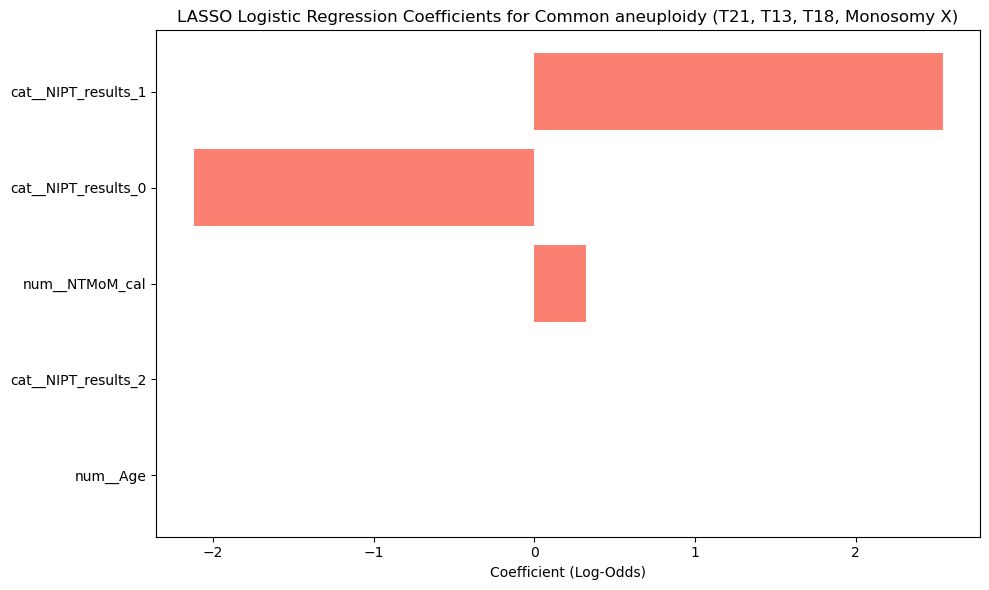

               Feature  Coefficient
0             num__Age     0.000000
4  cat__NIPT_results_2     0.000000
1       num__NTMoM_cal     0.324231
2  cat__NIPT_results_0    -2.120791
3  cat__NIPT_results_1     2.541127


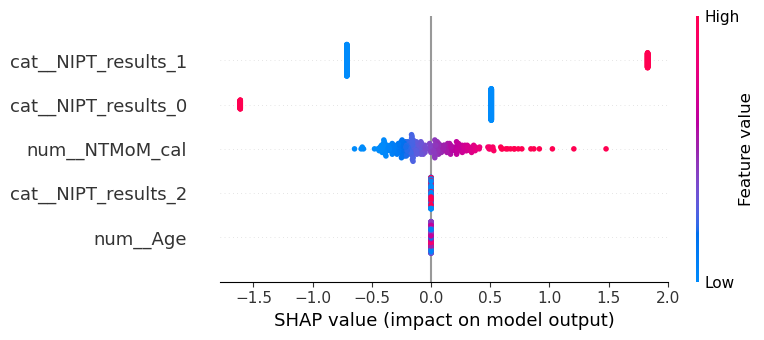


==== Coefficient and SHAP Analysis (LASSO) for SAB ====


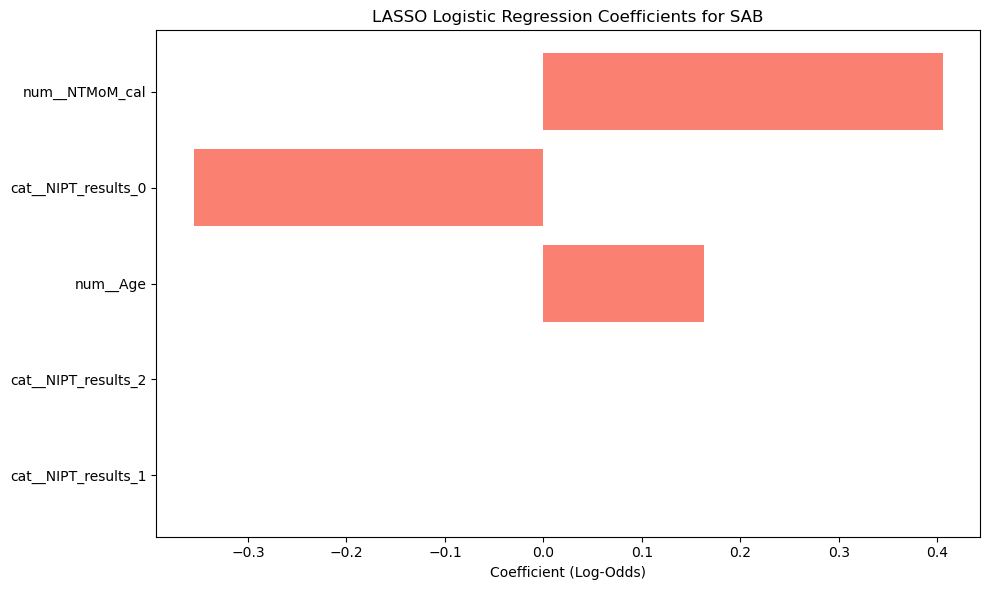

               Feature  Coefficient
3  cat__NIPT_results_1     0.000000
4  cat__NIPT_results_2     0.000000
0             num__Age     0.162963
2  cat__NIPT_results_0    -0.355033
1       num__NTMoM_cal     0.405152


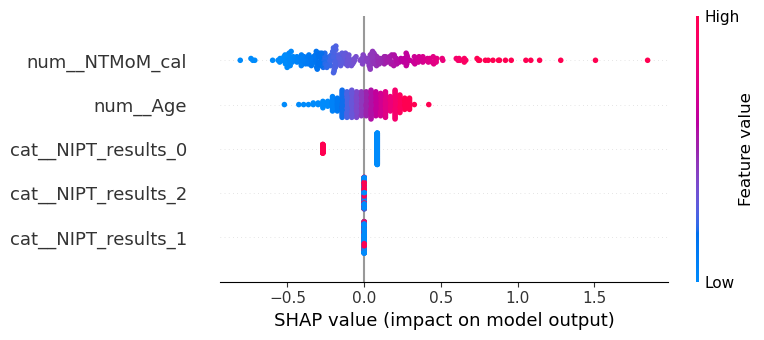


==== Coefficient and SHAP Analysis (LASSO) for Livebirth ====


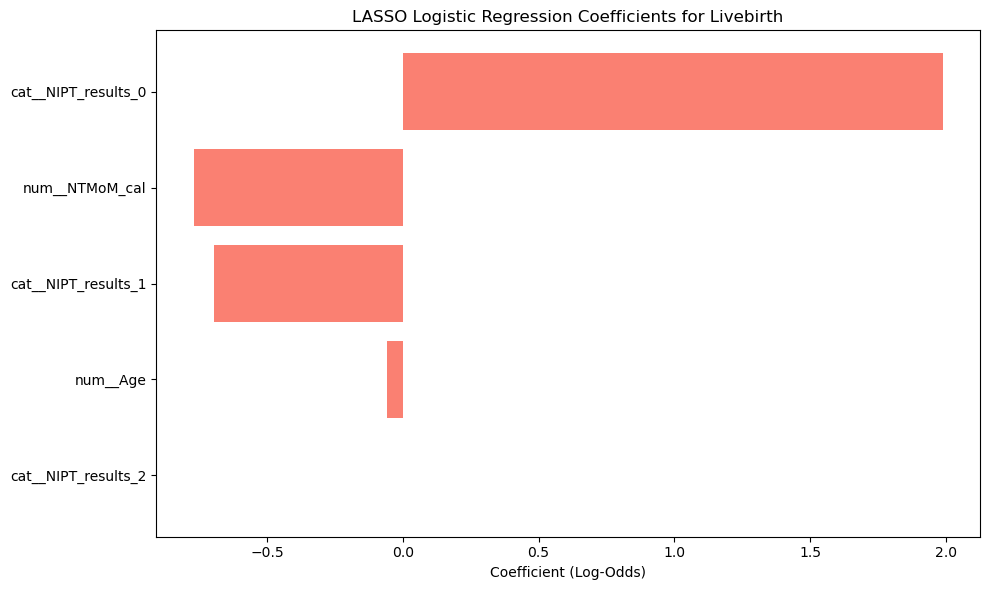

               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age    -0.059324
3  cat__NIPT_results_1    -0.696446
1       num__NTMoM_cal    -0.769503
2  cat__NIPT_results_0     1.987077


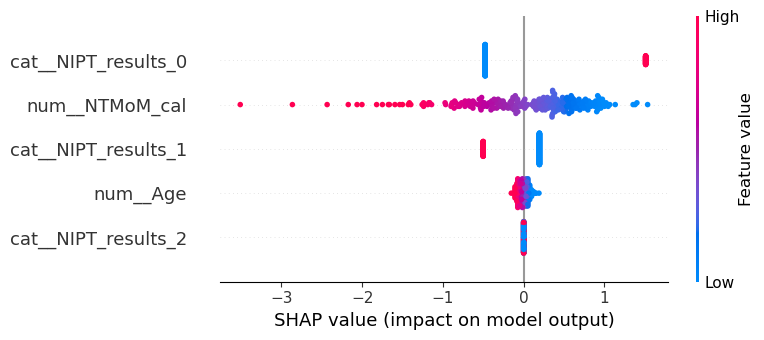


==== Coefficient and SHAP Analysis (LASSO) for Trisomy 21 (Down syndrome) ====


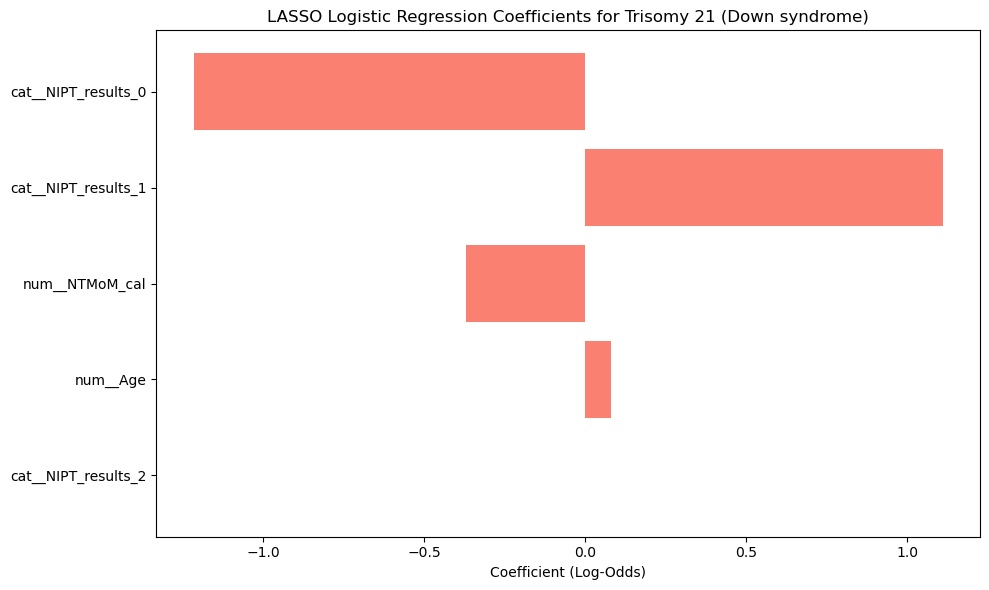

               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.078217
1       num__NTMoM_cal    -0.370998
3  cat__NIPT_results_1     1.109225
2  cat__NIPT_results_0    -1.216124


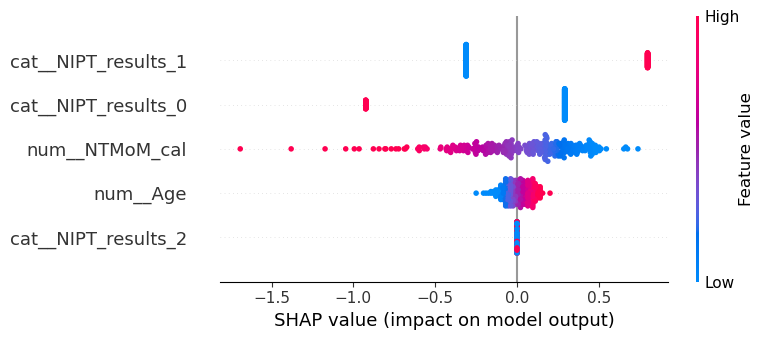


==== Coefficient and SHAP Analysis (LASSO) for Trisomy 18 ====


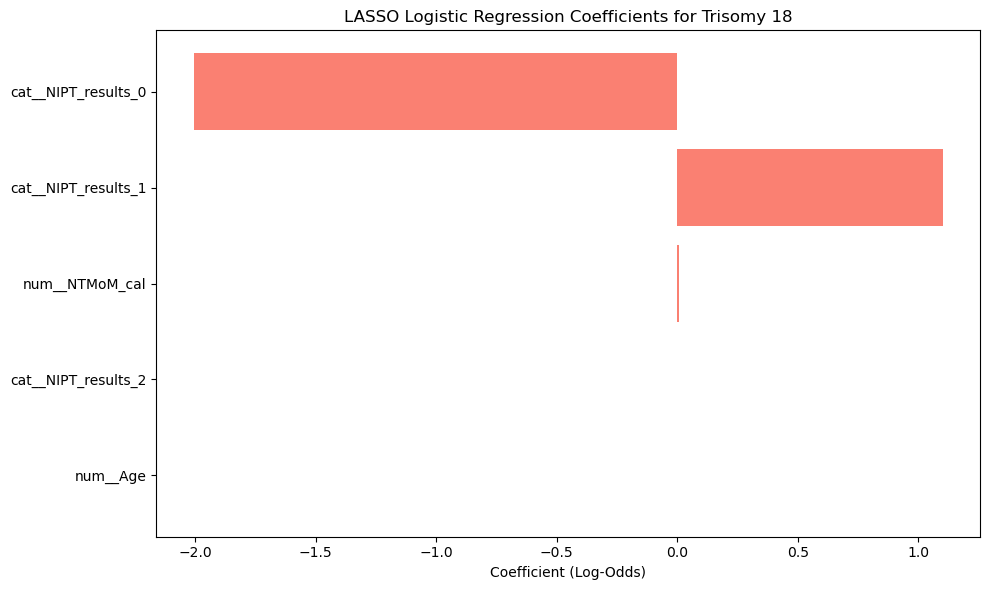

               Feature  Coefficient
0             num__Age     0.000000
4  cat__NIPT_results_2     0.000000
1       num__NTMoM_cal     0.008112
3  cat__NIPT_results_1     1.100860
2  cat__NIPT_results_0    -2.005515


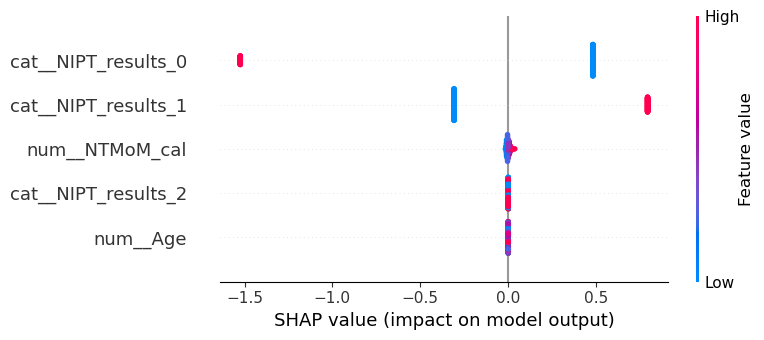


==== Coefficient and SHAP Analysis (LASSO) for Trisomy 13 ====


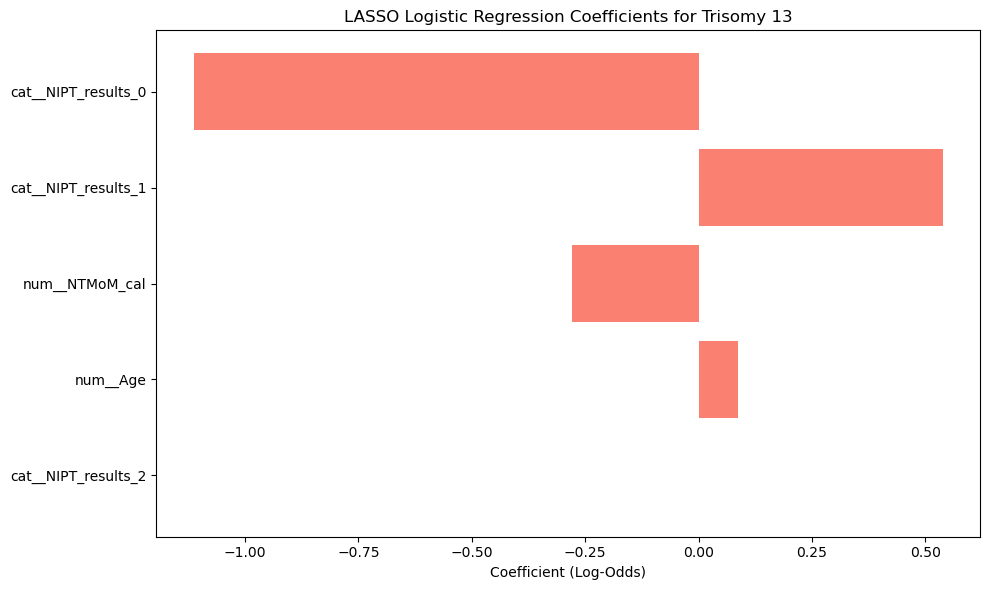

               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.085808
1       num__NTMoM_cal    -0.278299
3  cat__NIPT_results_1     0.537800
2  cat__NIPT_results_0    -1.112946


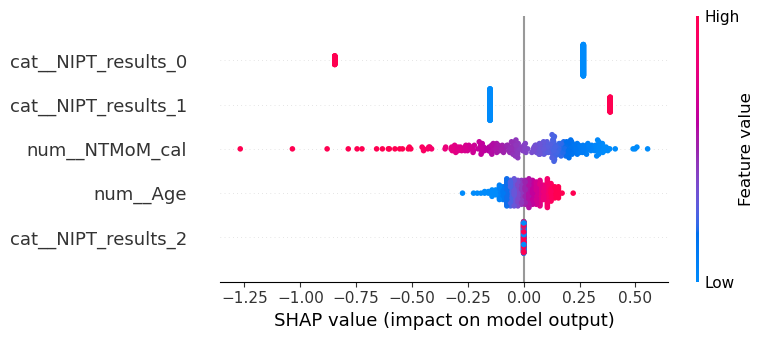


==== Coefficient and SHAP Analysis (LASSO) for Monosomy X (Turner syndrome) ====


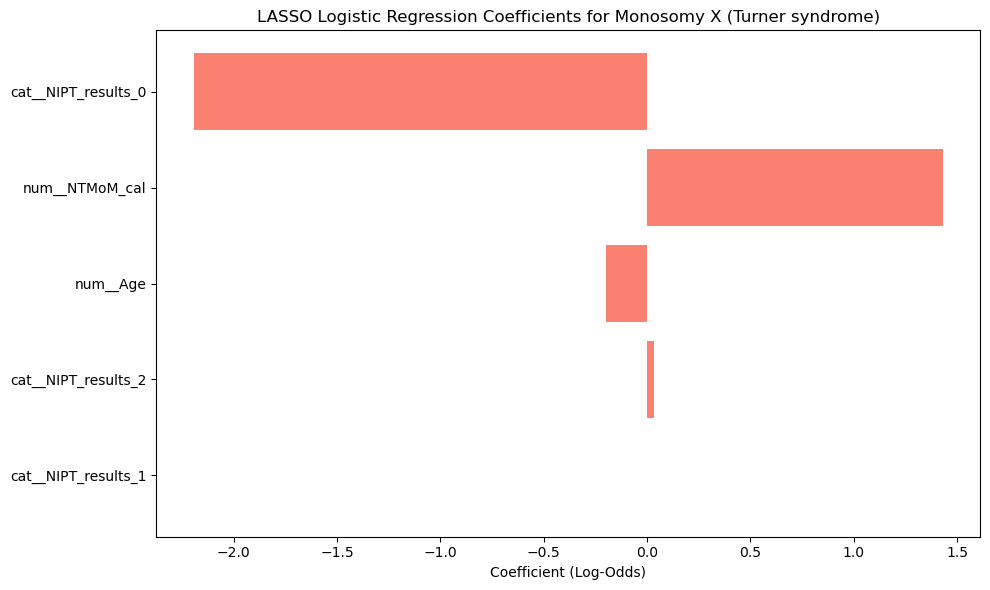

               Feature  Coefficient
3  cat__NIPT_results_1     0.000000
4  cat__NIPT_results_2     0.034424
0             num__Age    -0.200273
1       num__NTMoM_cal     1.429628
2  cat__NIPT_results_0    -2.194401


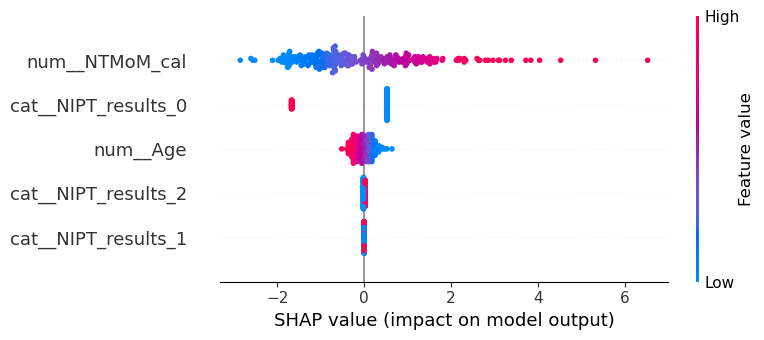


==== Coefficient and SHAP Analysis (LASSO) for Other genetic diagnoses ====


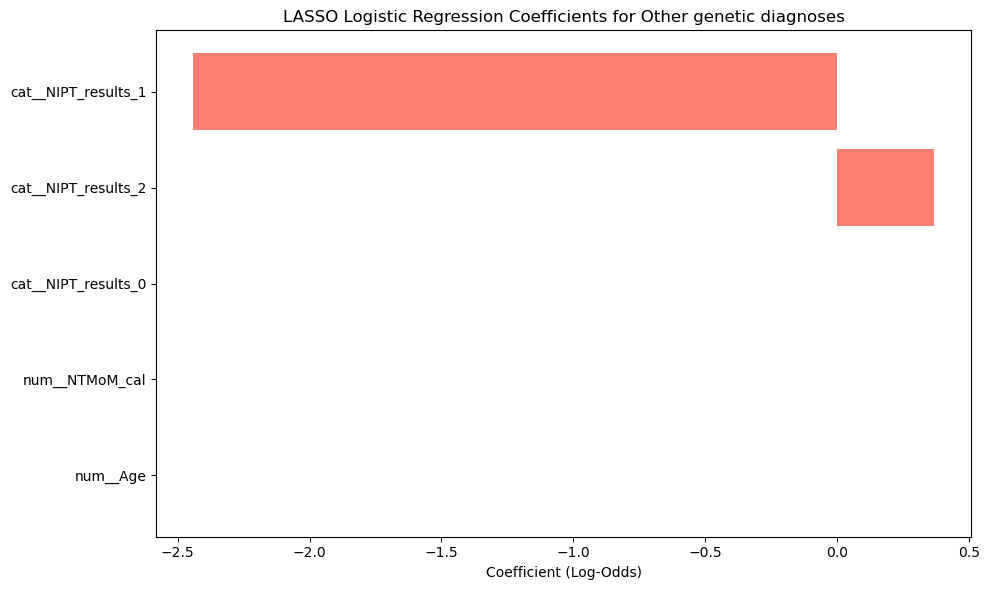

               Feature  Coefficient
0             num__Age     0.000000
1       num__NTMoM_cal     0.000000
2  cat__NIPT_results_0     0.000000
4  cat__NIPT_results_2     0.367188
3  cat__NIPT_results_1    -2.441416


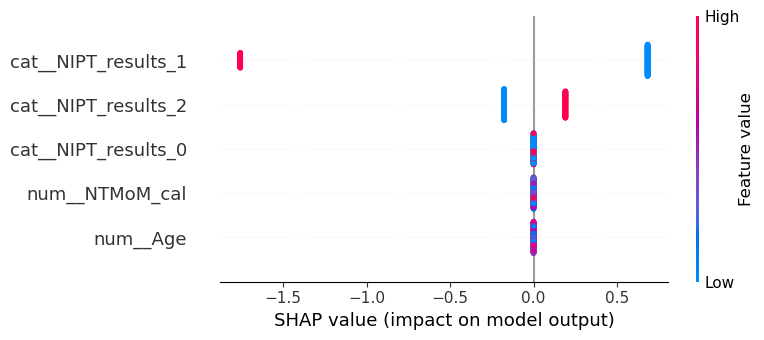

In [35]:
# Loop through each target and do coefficient + SHAP
for target in ['Composite', 'Anomaly', 'Common aneuploidy (T21, T13, T18, Monosomy X)',
    'SAB', 'Livebirth', 
    "Trisomy 21 (Down syndrome)", "Trisomy 18", "Trisomy 13",
    "Monosomy X (Turner syndrome)", "Other genetic diagnoses"]:
    if target not in data.columns:
        print(f"{target} not found in data, skipping.")
        continue

    print(f"\n==== Coefficient and SHAP Analysis (LASSO) for {target} ====")

    data_target = data[pd.to_numeric(data[target], errors='coerce').notna()].copy()
    data_target[target] = pd.to_numeric(data_target[target], errors='coerce').astype(int)

    X = data_target[continuous_vars + categorical_vars].copy()
    y = data_target[target]

    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', IterativeImputer(random_state=42)),
            ('scaler', StandardScaler())
        ]), continuous_vars),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_vars)
    ])

    lasso_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            penalty='l1',
            solver='saga',  # Required for L1 penalty
            max_iter=1000,
            C=1.0,
            l1_ratio=1.0,  # Use this instead of penalty='l1'
            random_state=42
        ))
    ])

    lasso_pipeline.fit(X, y)

    # Coefficients
    feature_names = preprocessor.get_feature_names_out()
    coefficients = lasso_pipeline.named_steps['classifier'].coef_[0]
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', key=abs, ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='salmon')
    plt.xlabel('Coefficient (Log-Odds)')
    plt.title(f'LASSO Logistic Regression Coefficients for {target}')
    plt.tight_layout()
    plt.show()
    print(coef_df)

    # SHAP
    X_preprocessed = preprocessor.fit_transform(X)
    explainer = shap.LinearExplainer(lasso_pipeline.named_steps['classifier'], X_preprocessed, feature_names=feature_names)
    shap_values = explainer.shap_values(X_preprocessed)

    shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names)


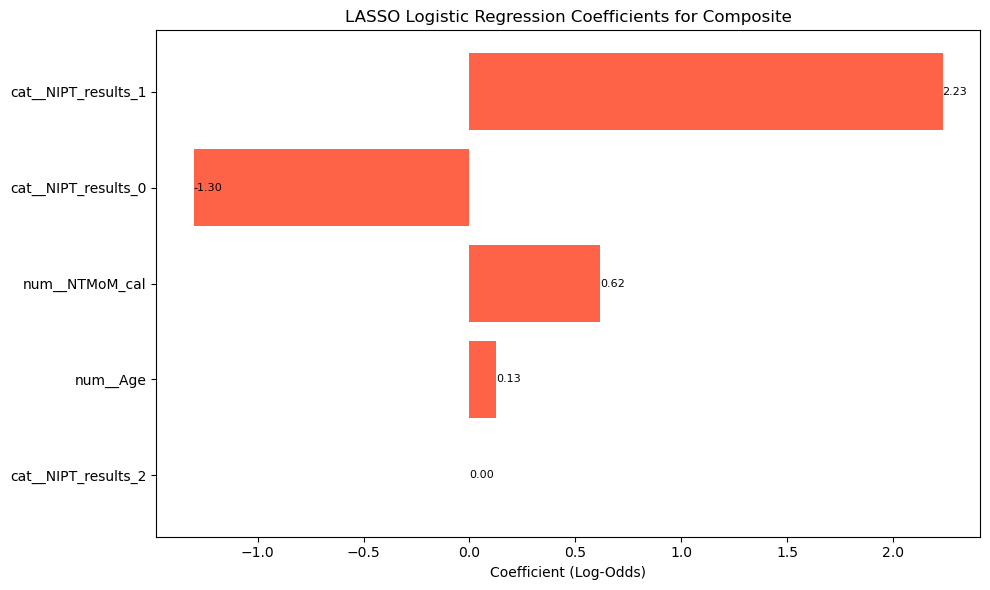

Saved: Composite_lasso_coefficients.png
               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.125887
1       num__NTMoM_cal     0.617502
2  cat__NIPT_results_0    -1.301769
3  cat__NIPT_results_1     2.233384
Saved: Composite_shap_summary_lasso.png


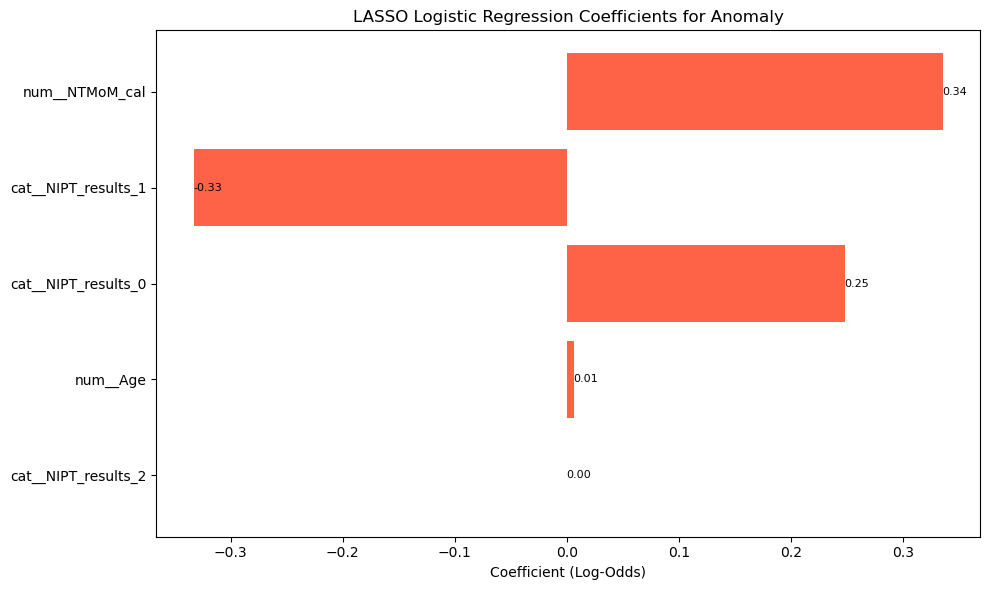

Saved: Anomaly_lasso_coefficients.png
               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.006262
2  cat__NIPT_results_0     0.248252
3  cat__NIPT_results_1    -0.333085
1       num__NTMoM_cal     0.335589
Saved: Anomaly_shap_summary_lasso.png


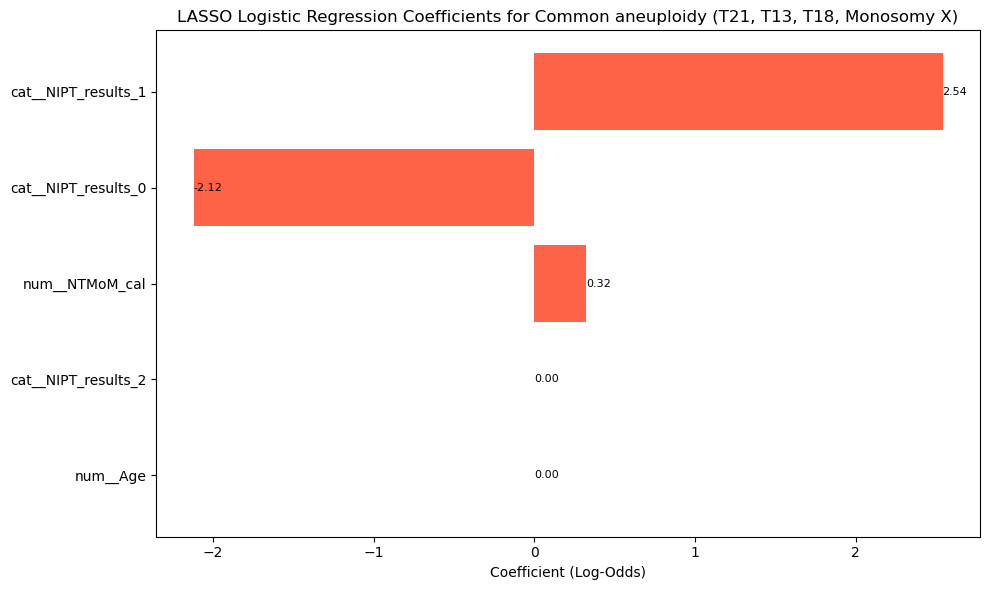

Saved: Common aneuploidy (T21, T13, T18, Monosomy X)_lasso_coefficients.png
               Feature  Coefficient
0             num__Age     0.000000
4  cat__NIPT_results_2     0.000000
1       num__NTMoM_cal     0.324231
2  cat__NIPT_results_0    -2.120791
3  cat__NIPT_results_1     2.541127
Saved: Common aneuploidy (T21, T13, T18, Monosomy X)_shap_summary_lasso.png


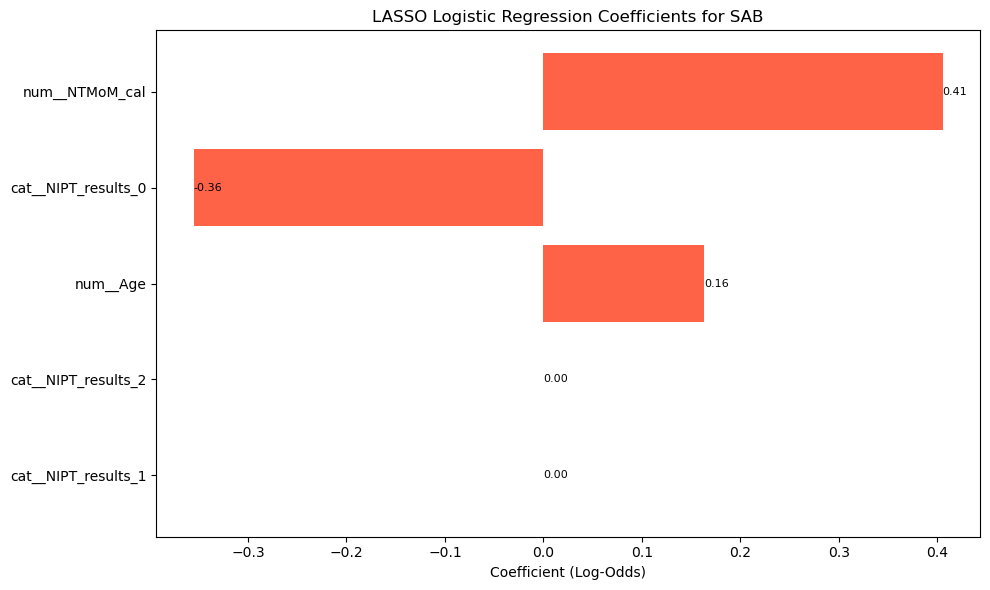

Saved: SAB_lasso_coefficients.png
               Feature  Coefficient
3  cat__NIPT_results_1     0.000000
4  cat__NIPT_results_2     0.000000
0             num__Age     0.162963
2  cat__NIPT_results_0    -0.355033
1       num__NTMoM_cal     0.405152
Saved: SAB_shap_summary_lasso.png


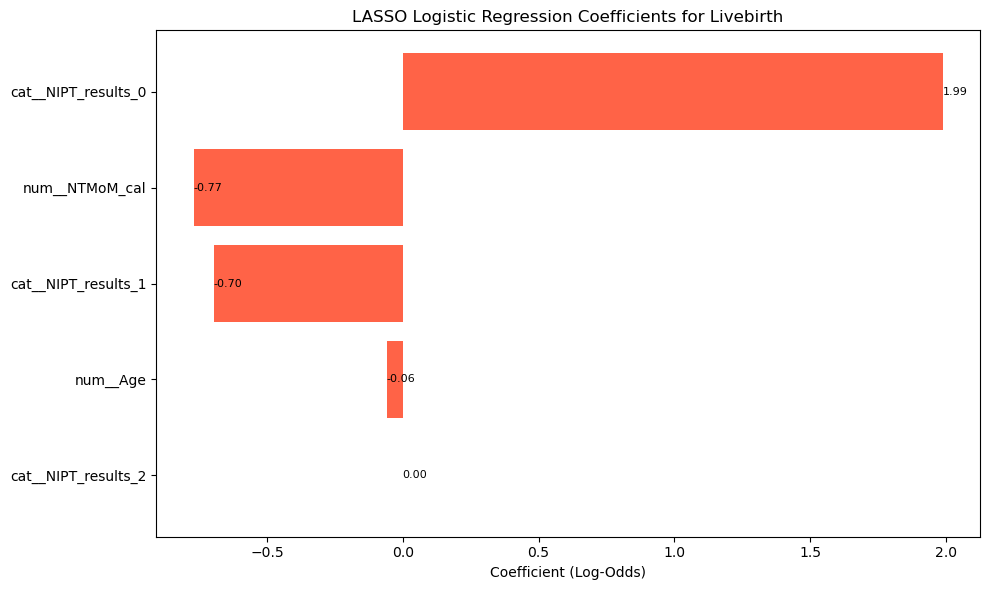

Saved: Livebirth_lasso_coefficients.png
               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age    -0.059324
3  cat__NIPT_results_1    -0.696446
1       num__NTMoM_cal    -0.769503
2  cat__NIPT_results_0     1.987077
Saved: Livebirth_shap_summary_lasso.png


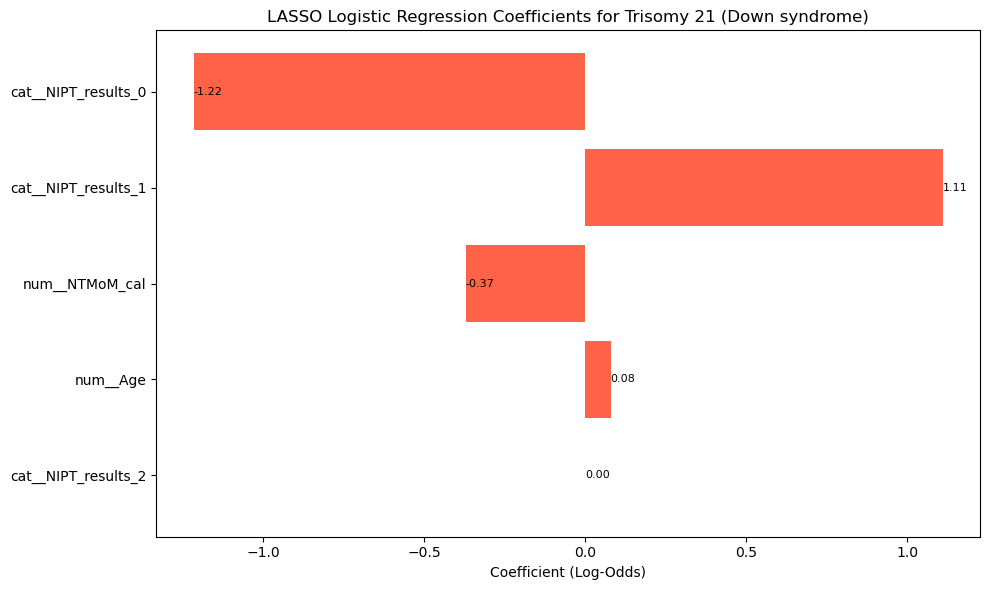

Saved: Trisomy 21 (Down syndrome)_lasso_coefficients.png
               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.078217
1       num__NTMoM_cal    -0.370998
3  cat__NIPT_results_1     1.109225
2  cat__NIPT_results_0    -1.216124
Saved: Trisomy 21 (Down syndrome)_shap_summary_lasso.png


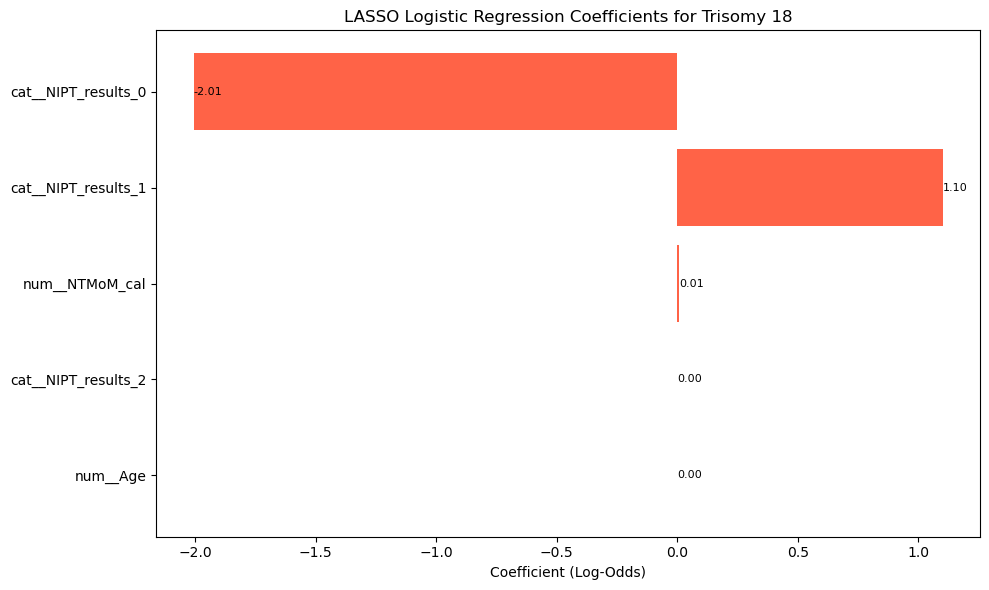

Saved: Trisomy 18_lasso_coefficients.png
               Feature  Coefficient
0             num__Age     0.000000
4  cat__NIPT_results_2     0.000000
1       num__NTMoM_cal     0.008112
3  cat__NIPT_results_1     1.100860
2  cat__NIPT_results_0    -2.005515
Saved: Trisomy 18_shap_summary_lasso.png


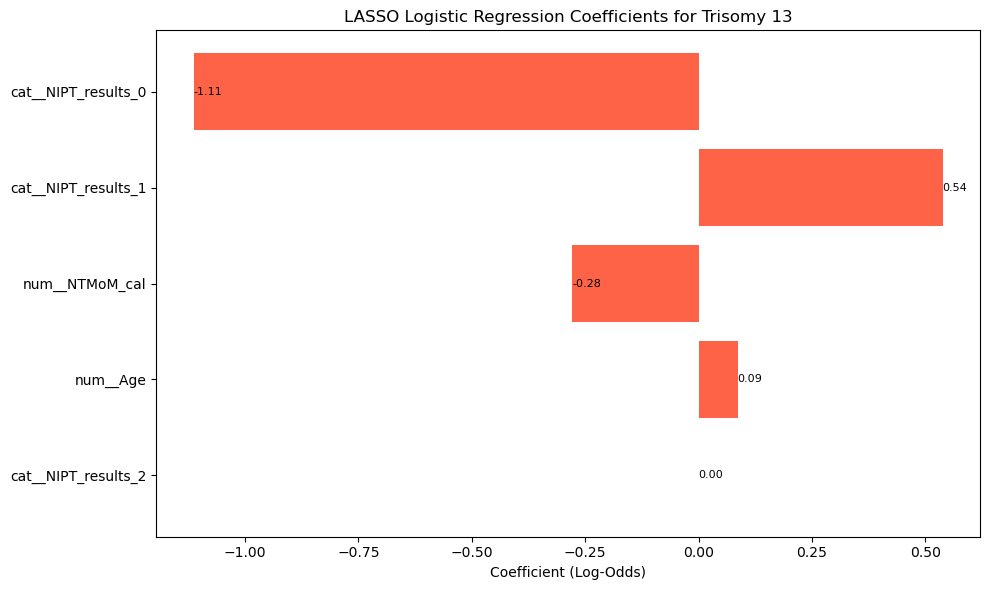

Saved: Trisomy 13_lasso_coefficients.png
               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.085808
1       num__NTMoM_cal    -0.278299
3  cat__NIPT_results_1     0.537800
2  cat__NIPT_results_0    -1.112946
Saved: Trisomy 13_shap_summary_lasso.png


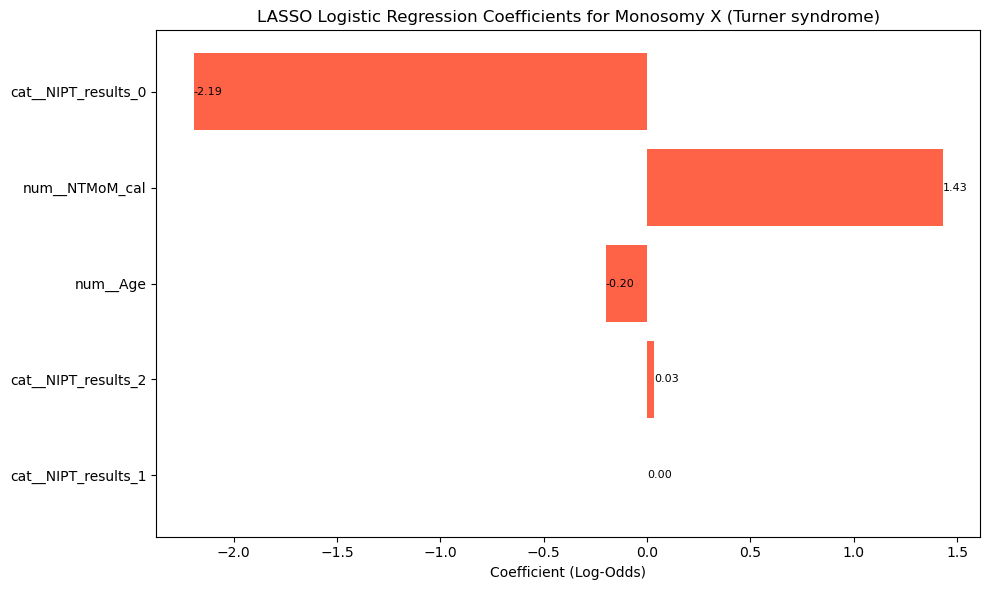

Saved: Monosomy X (Turner syndrome)_lasso_coefficients.png
               Feature  Coefficient
3  cat__NIPT_results_1     0.000000
4  cat__NIPT_results_2     0.034424
0             num__Age    -0.200273
1       num__NTMoM_cal     1.429628
2  cat__NIPT_results_0    -2.194401
Saved: Monosomy X (Turner syndrome)_shap_summary_lasso.png


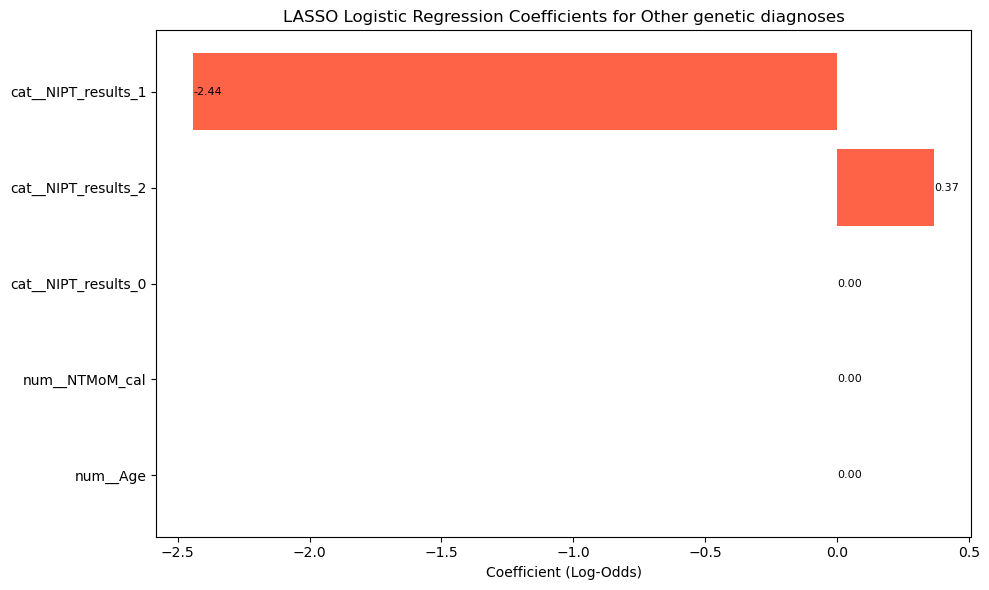

Saved: Other genetic diagnoses_lasso_coefficients.png
               Feature  Coefficient
0             num__Age     0.000000
1       num__NTMoM_cal     0.000000
2  cat__NIPT_results_0     0.000000
4  cat__NIPT_results_2     0.367188
3  cat__NIPT_results_1    -2.441416
Saved: Other genetic diagnoses_shap_summary_lasso.png


In [39]:
for target in ['Composite', 'Anomaly', 'Common aneuploidy (T21, T13, T18, Monosomy X)',
    'SAB', 'Livebirth', 
    "Trisomy 21 (Down syndrome)", "Trisomy 18", "Trisomy 13",
    "Monosomy X (Turner syndrome)", "Other genetic diagnoses"]:
    if target not in data.columns:
        print(f"{target} not found in data, skipping.")
        continue

    data_target = data[pd.to_numeric(data[target], errors='coerce').notna()].copy()
    data_target[target] = pd.to_numeric(data_target[target], errors='coerce').astype(int)
    X = data_target[continuous_vars + categorical_vars].copy()
    y = data_target[target]

    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', IterativeImputer(random_state=42)),
            ('scaler', StandardScaler())
        ]), continuous_vars),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_vars)
    ])

    lasso_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            penalty='l1',
            solver='saga',  # Required for L1 penalty
            max_iter=1000,
            C=1.0,
            l1_ratio=1.0,  # Use this instead of penalty='l1'
            random_state=42
        ))
    ])

    lasso_pipeline.fit(X, y)
    feature_names = preprocessor.get_feature_names_out()
    coefficients = lasso_pipeline.named_steps['classifier'].coef_[0]
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients}).sort_values(by='Coefficient', key=abs, ascending=True)

    # Coefficient bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='tomato')
    plt.xlabel('Coefficient (Log-Odds)')
    plt.title(f'LASSO Logistic Regression Coefficients for {target}')
    plt.tight_layout()

    # Add value labels to bars
    for bar, coef in zip(bars, coef_df['Coefficient']):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{coef:.2f}',
                 va='center', ha='left', fontsize=8)

    plt.savefig(f"{target}_lasso_coefficients.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {target}_lasso_coefficients.png")
    print(coef_df)

    # SHAP summary plot
    X_preprocessed = preprocessor.fit_transform(X)
    explainer = shap.LinearExplainer(lasso_pipeline.named_steps['classifier'], X_preprocessed, feature_names=feature_names)
    shap_values = explainer.shap_values(X_preprocessed)

    shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names, show=False)
    plt.savefig(f"{target}_shap_summary_lasso.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {target}_shap_summary_lasso.png")


In [43]:
# Define variables
continuous_vars = ['Age', 'NTMoM_cal']
categorical_vars = ['NIPT_results']
target_vars = ['Composite', 'Anomaly', 'Common aneuploidy (T21, T13, T18, Monosomy X)',
    'SAB', 'Livebirth', 
    "Trisomy 21 (Down syndrome)", "Trisomy 18", "Trisomy 13",
    "Monosomy X (Turner syndrome)", "Other genetic diagnoses"]

# Drop rows with missing or '.' in target variables
initial_rows = data.shape[0]
data = data[~data[target_vars].isnull().any(axis=1)]
data = data[~(data[target_vars] == ".").any(axis=1)]
print(f"\nDropped rows with missing or '.' in targets: {initial_rows - data.shape[0]}")

# Convert 'NIPT_results' to numeric, treat bad entries as 2
data['NIPT_results'] = pd.to_numeric(data['NIPT_results'], errors='coerce').fillna(2).astype(int)
nipt_mapping = {
    0: "NIPT Normal",
    1: "NIPT Abnormal",
    2: "NIPT Not Reported"
}
data['NIPT_results_display'] = data['NIPT_results'].map(nipt_mapping)

# Convert continuous vars to numeric
for col in continuous_vars:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), continuous_vars),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_vars)
])

# Bootstrapping
n_bootstraps = 1000

for target in target_vars:
    if target not in data.columns:
        print(f"{target} not found, skipping.")
        continue

    print(f"\nBootstrapping LASSO models for {target}...")
    models = []

    # Subset valid target data and drop rows with missing predictors
    df_target = data[pd.to_numeric(data[target], errors='coerce').notna()].copy()
    df_target[target] = pd.to_numeric(df_target[target], errors='coerce').astype(int)
    df_target = df_target.dropna(subset=continuous_vars + categorical_vars)

    for i in range(n_bootstraps):
        boot_data = resample(df_target, replace=True, random_state=i)
        X = boot_data[continuous_vars + categorical_vars]
        y = boot_data[target]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(
                penalty='l1',
                solver='saga',
                max_iter=1000,
                C=1.0,
                l1_ratio=1.0,  # NEW: Use this instead of penalty='l1'
                random_state=42
            ))
        ])

        pipeline.fit(X, y)
        models.append(pipeline)

    with open(f'bootstrapped_lasso_models_{target}.pkl', 'wb') as f:
        pickle.dump(models, f)

    print(f"✅ Saved bootstrapped LASSO models for {target}")

print("\n🎉 All bootstrapped LASSO models saved.")



Dropped rows with missing or '.' in targets: 0

Bootstrapping LASSO models for Composite...
✅ Saved bootstrapped LASSO models for Composite

Bootstrapping LASSO models for Anomaly...
✅ Saved bootstrapped LASSO models for Anomaly

Bootstrapping LASSO models for Common aneuploidy (T21, T13, T18, Monosomy X)...
✅ Saved bootstrapped LASSO models for Common aneuploidy (T21, T13, T18, Monosomy X)

Bootstrapping LASSO models for SAB...
✅ Saved bootstrapped LASSO models for SAB

Bootstrapping LASSO models for Livebirth...
✅ Saved bootstrapped LASSO models for Livebirth

Bootstrapping LASSO models for Trisomy 21 (Down syndrome)...
✅ Saved bootstrapped LASSO models for Trisomy 21 (Down syndrome)

Bootstrapping LASSO models for Trisomy 18...
✅ Saved bootstrapped LASSO models for Trisomy 18

Bootstrapping LASSO models for Trisomy 13...
✅ Saved bootstrapped LASSO models for Trisomy 13

Bootstrapping LASSO models for Monosomy X (Turner syndrome)...
✅ Saved bootstrapped LASSO models for Monosomy X (

In [45]:
###################### T2 Calculator ############################
# ------------------- CH-FILTERED SETUP -------------------
outcomes_CH = ['Anomaly', 'SAB', 'Livebirth', 'Other genetic diagnoses']
continuous_vars_CH = ['NTMoM_cal']
categorical_vars_CH = ['ResolvedCH']

# ------------------- FILTER & CLEAN CH-FOCUSED DATA -------------------
data_filtered_CH = data.copy()

# Keep only rows where T21, T18, T13, Turners == 0
data_filtered_CH = data_filtered_CH[
    (data_filtered_CH[["Trisomy 21 (Down syndrome)", "Trisomy 18", "Trisomy 13",
    "Monosomy X (Turner syndrome)"]] == 0).all(axis=1)
]

# Coerce ResolvedCH to numeric and assign unknowns to 2
data_filtered_CH['ResolvedCH'] = pd.to_numeric(data_filtered_CH['ResolvedCH'], errors='coerce').fillna(2).astype(int)

# Drop rows with missing predictor variables
data_filtered_CH = data_filtered_CH.dropna(subset=continuous_vars_CH)

print(f"Filtered CH data size (including unknown ResolvedCH as 2): {data_filtered_CH.shape}")

Filtered CH data size (including unknown ResolvedCH as 2): (111, 17)


In [47]:
# ------------------- CHECK DISTINCT VALUES -------------------
print("\nDistinct values in 'ResolvedCH' after cleaning:")
print(data_filtered_CH['ResolvedCH'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'ResolvedCH':")
print(data_filtered_CH['ResolvedCH'].unique())


Distinct values in 'ResolvedCH' after cleaning:
ResolvedCH
0    41
1    25
2    45
Name: count, dtype: int64

Unique values in 'ResolvedCH':
[0 2 1]


In [49]:
# Drop rows with missing predictor variables
data_filtered_CH = data_filtered_CH.dropna(subset=continuous_vars_CH)

# Keep only known ResolvedCH values (0 or 1)
data_filtered_CH = data_filtered_CH[data_filtered_CH['ResolvedCH'].isin([0, 1])]

print(f"Filtered CH data size with ResolvedCH = 0 or 1 only: {data_filtered_CH.shape}")

print("\nUnique values in 'Composite':")
print(data_filtered_CH['Composite'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'ResolvedCH':")
print(data_filtered_CH['ResolvedCH'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'Anomaly':")
print(data_filtered_CH['Anomaly'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'SAB':")
print(data_filtered_CH['SAB'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'Livebirth':")
print(data_filtered_CH['Livebirth'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'OtherChroms':")
print(data_filtered_CH['Other genetic diagnoses'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'T21':")
print(data_filtered_CH['Trisomy 21 (Down syndrome)'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'T18':")
print(data_filtered_CH['Trisomy 18'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'T13':")
print(data_filtered_CH['Trisomy 13'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'Turners':")
print(data_filtered_CH['Monosomy X (Turner syndrome)'].value_counts(dropna=False).sort_index())

print(data_filtered_CH['ResolvedCH'].value_counts(dropna=False))

Filtered CH data size with ResolvedCH = 0 or 1 only: (66, 17)

Unique values in 'Composite':
Composite
0.0    37
1.0    29
Name: count, dtype: int64

Unique values in 'ResolvedCH':
ResolvedCH
0    41
1    25
Name: count, dtype: int64

Unique values in 'Anomaly':
Anomaly
0    45
1    21
Name: count, dtype: int64

Unique values in 'SAB':
SAB
0    63
1     3
Name: count, dtype: int64

Unique values in 'Livebirth':
Livebirth
0    13
1    53
Name: count, dtype: int64

Unique values in 'OtherChroms':
Other genetic diagnoses
0.0    54
1.0    12
Name: count, dtype: int64

Unique values in 'T21':
Trisomy 21 (Down syndrome)
0.0    66
Name: count, dtype: int64

Unique values in 'T18':
Trisomy 18
0.0    66
Name: count, dtype: int64

Unique values in 'T13':
Trisomy 13
0.0    66
Name: count, dtype: int64

Unique values in 'Turners':
Monosomy X (Turner syndrome)
0.0    66
Name: count, dtype: int64
ResolvedCH
0    41
1    25
Name: count, dtype: int64


In [65]:
# ------------------- DEFINE MODELS -------------------
models_CH = {
    'Lasso_Logistic_Regression': LogisticRegression(solver='saga', max_iter=1000, C=1.0, l1_ratio=1.0, random_state=42),
    'Ridge_Logistic_Regression': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, C=1.0, random_state=42),
    'Random_Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM_RBF': SVC(kernel='rbf', probability=True, random_state=42),
    'SVM_Linear': SVC(kernel='linear', probability=True, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'Naive_Bayes': BernoulliNB(),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=2000, random_state=42)
}

# ------------------- PREPROCESSOR -------------------
preprocessor_CH = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), continuous_vars_CH),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_vars_CH)
])

In [67]:
# ------------------- DEFINE METRICS -------------------
scorers_CH = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef),
    'roc_auc': 'roc_auc'
}

# ------------------- EVALUATE & SELECT BEST MODEL -------------------
best_models_CH = {}
for outcome in outcomes_CH:
    print(f"\n==== Evaluating for target: {outcome} ====")
    df_target_CH = data_filtered_CH.copy()
    df_target_CH[outcome] = pd.to_numeric(df_target_CH[outcome], errors='coerce')
    df_target_CH = df_target_CH.dropna(subset=[outcome])
    
    X_CH = df_target_CH[continuous_vars_CH + categorical_vars_CH]
    y_CH = df_target_CH[outcome].astype(int)
    
    # CHECK IF WE HAVE ENOUGH SAMPLES FOR SMOTE
    min_class_count = y_CH.value_counts().min()
    use_smote = min_class_count >= 6  # SMOTE needs at least 6 samples
    
    if not use_smote:
        print(f"⚠️  Skipping SMOTE for {outcome} (only {min_class_count} minority samples)")
    
    results_dict = {}
    best_score = -np.inf
    best_model_name = None
    
    for name, model in models_CH.items():
        # Conditionally add SMOTE
        if use_smote:
            pipeline_CH = ImbPipeline([
                ('preprocessor', preprocessor_CH),
                ('smote', SMOTE(random_state=42)),
                ('classifier', model)
            ])
        else:
            pipeline_CH = Pipeline([
                ('preprocessor', preprocessor_CH),
                ('classifier', model)
            ])
        
        try:
            cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            scores = cross_validate(pipeline_CH, X_CH, y_CH, scoring=scorers_CH, cv=cv_strategy, n_jobs=-1)
            avg_scores = {metric: np.mean(scores[f'test_{metric}']) for metric in scorers_CH}
            results_dict[name] = avg_scores
            
            if avg_scores['roc_auc'] > best_score:
                best_score = avg_scores['roc_auc']
                best_model_name = name
        except Exception as e:
            print(f"{name} failed: {e}")
    
    # Print metrics
    metrics_df = pd.DataFrame(results_dict).T
    print(f"\nResults for {outcome}:\n")
    print(metrics_df.round(6))
    
    best_models_CH[outcome] = best_model_name
    print(f"\n✅ Best CH model for {outcome}: {best_model_name} (ROC AUC = {best_score:.4f})\n")


==== Evaluating for target: Anomaly ====

Results for Anomaly:

                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.606061   0.461310  0.809524  0.567288  0.329654   
Ridge_Logistic_Regression  0.606061   0.461310  0.809524  0.567288  0.329654   
Random_Forest              0.575758   0.384046  0.476190  0.411111  0.097918   
SVM_RBF                    0.590909   0.437500  0.714286  0.498024  0.267184   
SVM_Linear                 0.621212   0.479167  0.857143  0.599034  0.371830   
XGBoost                    0.651515   0.490404  0.619048  0.527290  0.284178   
Naive_Bayes                0.636364   0.493056  0.904762  0.626812  0.413356   
KNN                        0.651515   0.510989  0.761905  0.596825  0.353840   
MLP                        0.590909   0.462255  0.761905  0.535024  0.299274   

                            roc_auc  
Lasso_Logistic_Regression  0.696825  
Ridge_Logistic_Regression  0.644444  
Random_Forest       

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklea


Results for SAB:

                           accuracy  precision  recall   f1       mcc  \
Lasso_Logistic_Regression  0.954545        0.0     0.0  0.0  0.000000   
Ridge_Logistic_Regression  0.954545        0.0     0.0  0.0  0.000000   
Random_Forest              0.909091        0.0     0.0  0.0 -0.028904   
SVM_RBF                    0.954545        0.0     0.0  0.0  0.000000   
SVM_Linear                 0.954545        0.0     0.0  0.0  0.000000   
XGBoost                    0.954545        0.0     0.0  0.0  0.000000   
Naive_Bayes                0.954545        0.0     0.0  0.0  0.000000   
KNN                        0.954545        0.0     0.0  0.0  0.000000   
MLP                        0.939394        0.0     0.0  0.0 -0.015873   

                            roc_auc  
Lasso_Logistic_Regression  0.373016  
Ridge_Logistic_Regression  0.507937  
Random_Forest              0.563492  
SVM_RBF                    0.507937  
SVM_Linear                 0.777778  
XGBoost               

In [69]:
print(data_filtered_CH['Other genetic diagnoses'].value_counts())


Other genetic diagnoses
0.0    54
1.0    12
Name: count, dtype: int64


In [71]:
## Bootstrapping without SMOTE (train on real-world data) and download the pkl files for STREAMLIT Development
# ------------------- BOOTSTRAP & SAVE MODELS FOR STREAMLIT -------------------
from sklearn.base import clone

boot_model_map = {
    'Anomaly': MLPClassifier(max_iter=2000, random_state=42),
    'Livebirth': BernoulliNB(),
    'Other genetic diagnoses': SVC(kernel='rbf', probability=True, random_state=42)
}

n_bootstraps = 1000

for outcome in ['Anomaly', 'Livebirth', 'Other genetic diagnoses']:
    print(f"\n📦 Bootstrapping {outcome} using {best_models_CH[outcome]}...")

    df_target_CH = data_filtered_CH.copy()
    df_target_CH[outcome] = pd.to_numeric(df_target_CH[outcome], errors='coerce')
    df_target_CH = df_target_CH.dropna(subset=[outcome])
    X_CH = df_target_CH[continuous_vars_CH + categorical_vars_CH]
    y_CH = df_target_CH[outcome].astype(int)

    models_boot = []

    for i in range(n_bootstraps):
        boot_df = resample(df_target_CH, replace=True, random_state=i)
        X_boot = boot_df[continuous_vars_CH + categorical_vars_CH]
        y_boot = boot_df[outcome].astype(int)

        # Define pipeline for current bootstrap
        pipeline = Pipeline([
            ('preprocessor', preprocessor_CH),
            ('classifier', clone(boot_model_map[outcome]))  # clone ensures fresh model each time
        ])

        try:
            pipeline.fit(X_boot, y_boot)
            models_boot.append(pipeline)
        except Exception as e:
            print(f"⚠️  Bootstrap {i} failed for {outcome}: {e}")

    with open(f'bootstrapped_{best_models_CH[outcome]}_models_{outcome}.pkl', 'wb') as f:
        pickle.dump(models_boot, f)

    print(f"✅ Saved: bootstrapped_{best_models_CH[outcome]}_models_{outcome}.pkl")



📦 Bootstrapping Anomaly using MLP...
✅ Saved: bootstrapped_MLP_models_Anomaly.pkl

📦 Bootstrapping Livebirth using Lasso_Logistic_Regression...
✅ Saved: bootstrapped_Lasso_Logistic_Regression_models_Livebirth.pkl

📦 Bootstrapping Other genetic diagnoses using Random_Forest...
✅ Saved: bootstrapped_Random_Forest_models_Other genetic diagnoses.pkl
